In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import datetime
import numpy as np
import random
import seaborn as sns

Specifying all the focal brands

In [ ]:
focal_brands = ['Sephora',
 'ULTA Beauty',
 'Olive Garden',
 'The Cheesecake Factory',
 'Target',
 'Walmart',
 'Anthropologie',
 "Victoria's Secret"]

Reading the social brands catalog to get visits later for each store

In [ ]:
brands_visits = pd.read_csv('../data/revision_visits_revenue_2019.csv')
brands_visits['brand_standard'] = brands_visits['brand'].apply(lambda x: x.strip().lower()) # For comparison with catalog.tsv
brands_visits['date'] = brands_visits['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
brands_visits = brands_visits.rename(columns={'brand': 'brand_visitation'})
brands_visits.head()

Reading Travel Time

In [ ]:
with open('../data/travel_time.pkl', 'rb') as file:
    travel_time_dict = pickle.load(file)
    
travel_time_keys = list(travel_time_dict.keys())
from_keys = [key[0] for key in travel_time_keys]
to_keys = [key[1] for key in travel_time_keys]
time_minutes = list(travel_time_dict.values())
time_minutes = [int(time_inst.split(' ')[0]) for time_inst in time_minutes]

travel_time = pd.DataFrame({'From_PLACEKEY': from_keys, 'To_PLACEKEY': to_keys, 'Time_mins': time_minutes})
travel_time.head()

Reading the statistics of the specific focal brand using the results of Part 2

In [ ]:
brand = focal_brands[1]
focal_brand_path = os.path.join('../part2_r_statistics', brand)
focal_brand_path

Reading all the neighboring brands results for the selected focal brand

In [ ]:
file_list = os.listdir(focal_brand_path)
result_file_list = [file for file in file_list if file.find('_result') != -1]

In [ ]:
result_df = pd.DataFrame()

for result_file in result_file_list:
    result_file_path = os.path.join(focal_brand_path, result_file)
    tmp_res_df = pd.read_csv(result_file_path, skiprows=1, float_precision="round_trip")
    # Removing all the records for ols and m_olsExp
    if 'filename' in tmp_res_df['filename'].tolist(): #Wrong input
        continue
    result_df = pd.concat([result_df, tmp_res_df], ignore_index=True)

In [ ]:
result_df = result_df[~result_df['type'].isin(['ols', 'm_olsExp'])].reset_index(drop=True)
result_df = result_df.replace('FALSE', False).replace('False', False)
# result_df.iloc[:,3:] = result_df.iloc[:,3:].astype('float64', copy=True)

In [ ]:
result_df

In [ ]:
sum(result_df['filename'].value_counts() == 1)

In [ ]:
sum(result_df['filename'].value_counts() == 2)

In [ ]:
sum(result_df['filename'].value_counts() == 3)

In [ ]:
sum(result_df['filename'].value_counts() == 4)

Only getting those brands who have values for all the four models

In [ ]:
count_list = result_df['filename'].value_counts()
valid_brands = count_list[count_list == 4].index.to_list() # having the values of all the four models
len(valid_brands)

In [ ]:
result_df = result_df[result_df['filename'].isin(valid_brands)]
result_df

Extract the significant neighboring brands whose p-values for all the models are significant (<0.05) i.e., X_Pr(>|t|)

In [ ]:
def filter_brands_pvalue(brand_pvalue):
    pvalues = brand_pvalue.values
    
    if (pvalues[0] < 0.05) and (pvalues[1] < 0.05) and (pvalues[2] < 0.05) and (pvalues[3] < 0.05):
        return True
    else:
        return False

In [ ]:
significant_brands = result_df.groupby('filename')['X_Pr(>|t|)'].apply(filter_brands_pvalue)
significant_brands_list = significant_brands [significant_brands == True].index.to_list()

In [ ]:
significant_brands_list

### Performing the calculations for WIC and WIBC

Firstly Calculating the Inverse and Inverse-Exp of the Time_mins

In [ ]:
travel_time['Time_mins_inv'] = 1/travel_time['Time_mins']
travel_time['Time_mins_inv_exp'] = 1/np.exp(travel_time['Time_mins'])
travel_time = travel_time.rename(columns={'From_PLACEKEY': 'Focal_Stores', 'To_PLACEKEY': 'Neib_Stores'})
travel_time

1. Extracting all the stores of the significant brands and focal store
2. Calculating the Average Visits of each store to be used as average sales
3. Dropping all the duplicate rows to have a clean dataframe

In [ ]:
brands_visits_focal_sig_neib = brands_visits[(brands_visits['brand_visitation'].isin(significant_brands_list)) | (brands_visits['brand_visitation']==brand)]
brands_visits_focal_sig_neib.loc[:,'avg_visits'] = brands_visits_focal_sig_neib.groupby('PLACEKEY')['visits_by_day'].transform('mean')
brands_visits_focal_sig_neib = brands_visits_focal_sig_neib.drop(columns=['date', 'visits_by_day', 'spend_by_day'])
brands_visits_focal_sig_neib = brands_visits_focal_sig_neib.drop_duplicates().reset_index(drop=True)
brands_visits_focal_sig_neib

Extracting the time_mins with all the focal stores belonging to brand under consideration, and all of the significant brands

In [ ]:
focal_stores = brands_visits_focal_sig_neib[brands_visits_focal_sig_neib['brand_visitation'] == brand]['PLACEKEY'].unique().tolist()
sig_neib_stores = brands_visits_focal_sig_neib[brands_visits_focal_sig_neib['brand_visitation'].isin(significant_brands_list)]['PLACEKEY'].unique().tolist()
travel_time_filtered = travel_time[(travel_time['Focal_Stores'].isin(focal_stores)) & (travel_time['Neib_Stores'].isin(sig_neib_stores))]
travel_time_filtered

Merging by Focal Stores to get the average visits of the focal stores

In [ ]:
travel_time_filtered = pd.merge(left=travel_time_filtered, right=brands_visits_focal_sig_neib, how='left', left_on='Focal_Stores', right_on='PLACEKEY')
travel_time_filtered = travel_time_filtered.drop(columns=['PLACEKEY', 'brand_standard']).rename(columns={'brand_visitation':'Foc_Brand', 'lat':'Foc_lat', 'lon':'Foc_lon', 'avg_visits': 'Foc_avg_visits'})
travel_time_filtered

Merging by Neighboring Stores to get the average visits of the neighboring stores

In [ ]:
travel_time_filtered = pd.merge(left=travel_time_filtered, right=brands_visits_focal_sig_neib, how='left', left_on='Neib_Stores', right_on='PLACEKEY')
travel_time_filtered = travel_time_filtered.drop(columns=['PLACEKEY','lat', 'lon', 'brand_standard']).rename(columns={'brand_visitation':'Neib_Brand', 'avg_visits': 'Neib_avg_visits'})
travel_time_filtered

#### Performing Neib Centrality Calculations by taking each neighboring brand

In [ ]:
def centrality_calc_reviews(group_df):
    neib_brand = group_df.name
    neib_result_df = result_df [result_df['filename'] == neib_brand]
    
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    est_reviews = neib_result_df[neib_result_df['type'] == 'fe_reviews_reviews']['X_Estimate'].values[0]
    est_reviews_exp = neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_reviews']['X_Estimate'].values[0]

    weighted_influence = np.sum(np.array(dist_l).dot(np.array(average_sales))*float(est_reviews))
    weighted_influence_exp = np.sum(np.array(dist2_l).dot(np.array(average_sales))*float(est_reviews_exp))
    influence = np.sum(np.array(dist_l)*float(est_reviews))
    influence_exp = np.sum(np.array(dist2_l)*float(est_reviews_exp))
    weighted_no_influence = np.sum(np.array(dist_l).dot(np.array(average_sales)))
    no_influence = np.sum(np.array(dist_l))
    avg_visits = np.mean(average_sales)
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    num_stores = group_df['Neib_Stores'].nunique()
    
    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp':influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores})

In [ ]:
neib_centrality_reviews = travel_time_filtered.groupby('Neib_Brand')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Stores']].apply(centrality_calc_reviews).reset_index()
neib_centrality_reviews

In [ ]:
def centrality_calc_visits(group_df):
    neib_brand = group_df.name
    neib_result_df = result_df [result_df['filename'] == neib_brand]
    
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    est_visits = neib_result_df[neib_result_df['type'] == 'fe_reviews_visits']['X_Estimate'].values[0]
    est_visits_exp = neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_visits']['X_Estimate'].values[0]

    weighted_influence = np.sum(np.array(dist_l).dot(np.array(average_sales))*float(est_visits))
    weighted_influence_exp = np.sum(np.array(dist2_l).dot(np.array(average_sales))*float(est_visits_exp))
    influence = np.sum(np.array(dist_l)*float(est_visits))
    influence_exp = np.sum(np.array(dist2_l)*float(est_visits_exp))
    weighted_no_influence = np.sum(np.array(dist_l).dot(np.array(average_sales)))
    no_influence = np.sum(np.array(dist_l))
    avg_visits = np.mean(average_sales)
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    num_stores = group_df['Neib_Stores'].nunique()
    
    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp':influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores})

In [ ]:
neib_centrality_visits = travel_time_filtered.groupby('Neib_Brand')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Stores']].apply(centrality_calc_visits).reset_index()
neib_centrality_visits

#### Performing Inner Centrality Calculations by taking each focal store

In [ ]:
def inner_centrality_calc_reviews(group_df):
        
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    
    est_reviews = []
    est_exp_reviews = []
    neib_brand_list = group_df['Neib_Brand'].values.tolist()
    for neib_brand in neib_brand_list:
        neib_result_df = result_df[result_df['filename'] == neib_brand]
        est_reviews.append(neib_result_df[neib_result_df['type'] == 'fe_reviews_reviews']['X_Estimate'].values[0])
        est_exp_reviews.append(neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_reviews']['X_Estimate'].values[0])

    weighted_influence = np.sum(np.array(est_reviews) * np.array(dist_l) * np.array(average_sales))
    weighted_influence_exp = np.sum(np.array(est_exp_reviews) * np.array(dist2_l) * np.array(average_sales))
    influence = np.sum(np.array(est_reviews) * np.array(dist_l))
    influence_exp = np.sum(np.array(est_exp_reviews) * np.array(dist2_l))
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    avg_visits = np.mean(average_sales)
    weighted_no_influence = np.sum(np.array(dist_l) * np.array(average_sales))
    no_influence = np.sum(np.array(dist_l))
    num_stores = group_df['Neib_Stores'].nunique()
    focal_lat = group_df['Foc_lat'].values[0]
    focal_lon = group_df['Foc_lon'].values[0]    


    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp': influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores,
                      'focal_lat': focal_lat, 'focal_lon': focal_lon})

In [ ]:
inner_centrality_reviews = travel_time_filtered.groupby('Focal_Stores')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Brand', 'Neib_Stores', 'Foc_lat', 'Foc_lon']].apply(inner_centrality_calc_reviews).reset_index()
inner_centrality_reviews

In [ ]:
def inner_centrality_calc_visits(group_df):
        
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    
    est_visits = []
    est_exp_visits = []
    neib_brand_list = group_df['Neib_Brand'].values.tolist()
    for neib_brand in neib_brand_list:
        neib_result_df = result_df[result_df['filename'] == neib_brand]
        est_visits.append(neib_result_df[neib_result_df['type'] == 'fe_reviews_visits']['X_Estimate'].values[0])
        est_exp_visits.append(neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_visits']['X_Estimate'].values[0])

    weighted_influence = np.sum(np.array(est_visits) * np.array(dist_l) * np.array(average_sales))
    weighted_influence_exp = np.sum(np.array(est_exp_visits) * np.array(dist2_l) * np.array(average_sales))
    influence = np.sum(np.array(est_visits) * np.array(dist_l))
    influence_exp = np.sum(np.array(est_exp_visits) * np.array(dist2_l))
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    avg_visits = np.mean(average_sales)
    weighted_no_influence = np.sum(np.array(dist_l) * np.array(average_sales))
    no_influence = np.sum(np.array(dist_l))
    num_stores = group_df['Neib_Stores'].nunique()
    focal_lat = group_df['Foc_lat'].values[0]
    focal_lon = group_df['Foc_lon'].values[0]    


    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp': influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores,
                      'focal_lat': focal_lat, 'focal_lon': focal_lon})

In [ ]:
inner_centrality_visits = travel_time_filtered.groupby('Focal_Stores')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Brand', 'Neib_Stores', 'Foc_lat', 'Foc_lon']].apply(inner_centrality_calc_visits).reset_index()
inner_centrality_visits

### Calculating the visits for all the businesses

For Reviews Model

In [ ]:
visits_all_business_pure_reviews = travel_time_filtered
visits_all_business_pure_reviews['Neib_est_review'] = visits_all_business_pure_reviews['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_reviews_reviews')]['X_Estimate'].values[0])
visits_all_business_pure_reviews['Neib_est_exp_review'] = visits_all_business_pure_reviews['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_exp_reviews_reviews')]['X_Estimate'].values[0])
visits_all_business_pure_reviews['num_inf'] = visits_all_business_pure_reviews['Neib_est_review'] * visits_all_business_pure_reviews['Time_mins_inv']
visits_all_business_pure_reviews['num_inf_exp'] = visits_all_business_pure_reviews['Neib_est_exp_review'] * visits_all_business_pure_reviews['Time_mins_inv_exp']
visits_all_business_pure_reviews['num_inf_visits'] = visits_all_business_pure_reviews['Neib_est_review'] * visits_all_business_pure_reviews['Time_mins_inv'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews['num_inf_visits_exp'] = visits_all_business_pure_reviews['Neib_est_exp_review'] * visits_all_business_pure_reviews['Time_mins_inv_exp'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews['weighted_visits'] = visits_all_business_pure_reviews['Time_mins_inv'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews.head()

In [ ]:
visits_all_business_pure_reviews = visits_all_business_pure_reviews.sort_values('num_inf_visits', ascending=False)

ranked_dic_reviews = visits_all_business_pure_reviews.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf', 'sum'),
                                                   num_inf_visits = ('num_inf_visits','sum')
                                                )
ranked_dic_reviews

In [ ]:
visits_all_business_pure_reviews = visits_all_business_pure_reviews.sort_values('num_inf_visits_exp', ascending=False)

ranked_dic_reviews_exp = visits_all_business_pure_reviews.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf_exp', 'sum'),
                                                   num_inf_visits = ('num_inf_visits_exp','sum')
                                                )
ranked_dic_reviews_exp

For Visits Model

In [ ]:
visits_all_business_pure_visits = travel_time_filtered
visits_all_business_pure_visits['Neib_est_visits'] = visits_all_business_pure_visits['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_reviews_visits')]['X_Estimate'].values[0])
visits_all_business_pure_visits['Neib_est_exp_visits'] = visits_all_business_pure_visits['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_exp_reviews_visits')]['X_Estimate'].values[0])
visits_all_business_pure_visits['num_inf'] = visits_all_business_pure_visits['Neib_est_visits'] * visits_all_business_pure_visits['Time_mins_inv']
visits_all_business_pure_visits['num_inf_exp'] = visits_all_business_pure_visits['Neib_est_exp_visits'] * visits_all_business_pure_visits['Time_mins_inv_exp']
visits_all_business_pure_visits['num_inf_visits'] = visits_all_business_pure_visits['Neib_est_visits'] * visits_all_business_pure_visits['Time_mins_inv'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits['num_inf_visits_exp'] = visits_all_business_pure_visits['Neib_est_exp_visits'] * visits_all_business_pure_visits['Time_mins_inv_exp'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits['weighted_visits'] = visits_all_business_pure_visits['Time_mins_inv'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits.head()

In [ ]:
visits_all_business_pure_visits = visits_all_business_pure_visits.sort_values('num_inf_visits', ascending=False)

ranked_dic_visits = visits_all_business_pure_visits.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf', 'sum'),
                                                   num_inf_visits = ('num_inf_visits','sum')
                                                )
ranked_dic_visits

In [ ]:
visits_all_business_pure_visits = visits_all_business_pure_visits.sort_values('num_inf_visits_exp', ascending=False)

ranked_dic_visits_exp = visits_all_business_pure_visits.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf_exp', 'sum'),
                                                   num_inf_visits = ('num_inf_visits_exp','sum')
                                                )
ranked_dic_visits_exp

### Example 1 Web Design

Create the folder to save the results

In [ ]:
dir_path = os.path.join('example1_web_design', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [ ]:
k = 7
top_selected_w = neib_centrality_reviews.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_reviews.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_reviews.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))


Exponential Reviews

In [ ]:
k = 7
top_selected_w = neib_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews_exp.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_reviews_exp.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_reviews_exp.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))


Linear Visits

In [ ]:
k = 7
top_selected_w = neib_centrality_visits.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_visits.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_visits.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [ ]:
k = 7
top_selected_w = neib_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits_exp.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_visits_exp.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_visits_exp.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 2 Choose Partner

Create the folder to save the results

In [ ]:
dir_path = os.path.join('example2_choose_partner', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [ ]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_reviews.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))

Exponential Reviews

In [ ]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews_exp.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))

Linear Visits

In [ ]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_visits.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [ ]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits_exp.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

In [ ]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 4 Inbound Centrality Budget Allocations

Create the folder to save the results

In [ ]:
dir_path = os.path.join('example4_inbound_centrality_budget_allocations', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [ ]:
visits_rage = [0.0203, 0.0603] 
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_reviews.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_reviews.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_reviews.sort_values('Time_mins_inv', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_reviews['num_inf_visits'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_reviews['num_inf_visits'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

In [ ]:
cnt = 0 
DAY = 30
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))

Exponential Reviews

In [ ]:
visits_rage = [0.0203, 0.0603] 
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_reviews.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_reviews.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_reviews.sort_values('Time_mins_inv_exp', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_reviews['num_inf_visits_exp'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_reviews['num_inf_visits_exp'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits_exp']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits_exp'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits_exp']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

In [ ]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))

Linear Visits

In [ ]:
visits_all_business_pure_visits.head()

In [ ]:
visits_rage = [0.0203, 0.0603]
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_visits.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_visits.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_visits.sort_values('Time_mins_inv', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_visits['num_inf_visits'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_visits['num_inf_visits'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

In [ ]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [ ]:
visits_rage = [0.0203, 0.0603]
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_visits.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_visits.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_visits.sort_values('Time_mins_inv_exp', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_visits['num_inf_visits_exp'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_visits['num_inf_visits_exp'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits_exp']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits_exp'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits_exp']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

In [ ]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 3: Inbound Centrality for Local Marketing Partnerships

Creating a folder to save results

In [ ]:
dir_path = os.path.join('example4_inbound_centrality_local_marketing', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [ ]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_reviews.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

#%%

top_selected_w = inner_centrality_reviews.sort_values('weighted_influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_reviews.sort_values('influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

In [ ]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))


Exponential Reviews

In [ ]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_reviews.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_reviews.sort_values('influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits_exp'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

In [ ]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))


Linear Visits

In [70]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_visits.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_visits.sort_values('weighted_influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_visits.sort_values('influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,0.014052,2.278162,2.278162,0.014175,2.278162,0.069092,0.069092,example_3_local_partner_choice
1,0.061287,2.020805,2.020805,0.012573,2.020805,0.061287,0.061287,example_3_local_partner_choice
2,0.234692,2.738946,2.738946,0.017042,2.738946,0.083067,0.083067,example_3_local_partner_choice
3,0.802435,4.097692,4.097692,0.025496,4.097692,0.124275,0.124275,example_3_local_partner_choice
4,0.010313,1.657438,1.657438,0.010313,1.657438,0.050267,0.050267,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,0.049351,1.627257,1.627257,0.010125,1.627257,0.049351,0.049351,example_3_local_partner_choice
96,0.511999,2.019729,2.019729,0.012567,2.019729,0.061254,0.061254,example_3_local_partner_choice
97,0.053514,3.176299,3.176299,0.019763,3.176299,0.096331,0.096331,example_3_local_partner_choice
98,0.007802,4.180976,4.180976,0.026014,4.180976,0.126801,0.126801,example_3_local_partner_choice


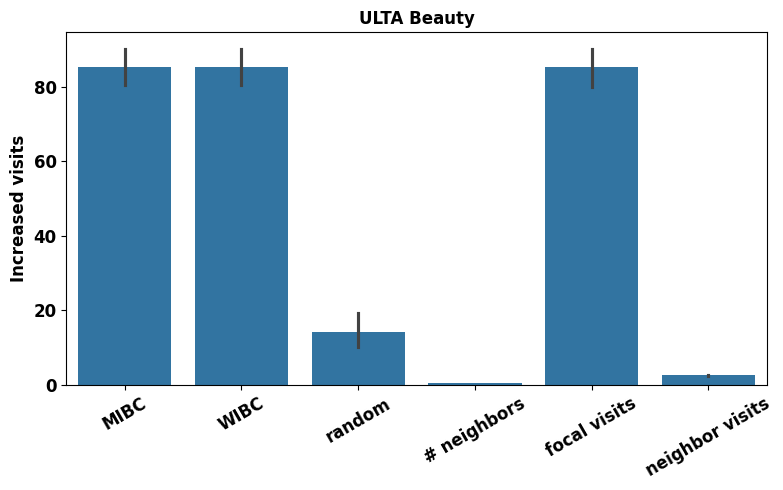

In [71]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [72]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_visits.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_visits.sort_values('influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits_exp'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,1.252345e-08,1.211471,1.211471,4.786177e-08,1.211471,0.012773,0.012773,example_3_local_partner_choice
1,-2.396196e+00,2.005101,2.005101,7.921581e-08,2.005101,0.021140,0.021140,example_3_local_partner_choice
2,3.554536e-01,2.056851,2.056851,8.126029e-08,2.056851,0.021686,0.021686,example_3_local_partner_choice
3,5.004584e-02,2.036534,2.036534,8.045762e-08,2.036534,0.021472,0.021472,example_3_local_partner_choice
4,7.323375e-08,1.853684,1.853684,7.323375e-08,1.853684,0.019544,0.019544,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,5.244502e-02,2.134164,2.134164,8.431471e-08,2.134164,0.022501,0.022501,example_3_local_partner_choice
96,-2.778237e-01,1.932059,1.932059,7.633012e-08,1.932059,0.020370,0.020370,example_3_local_partner_choice
97,-1.073211e-05,1.784959,1.784959,7.051861e-08,1.784959,0.018819,0.018819,example_3_local_partner_choice
98,-3.343275e+00,2.797603,2.797603,1.105253e-07,2.797603,0.029496,0.029496,example_3_local_partner_choice


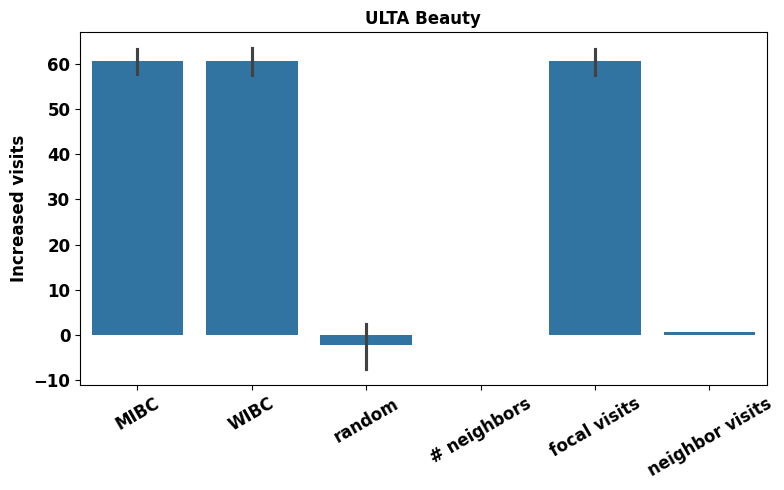

In [73]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))